


**Security and Privacy in Machine Learning**


**HW3**


**Full Name: Hamidreza Amirzadeh**

**Student Number: 401206999**

# **Preface (MUST READ :))**
In this notebook you will firstly train a simple CNN and apply the FGSM attack on it to craft adversarial examples, then you wil launch adversaial training on the same CNN architecture, using your method for crafting adversarial examples. Afterwards you will evaluate the  robustness of the defended CNN against PGD attack and then compare the results of this attack on the defended CNN in different settings.

P.S.1 Reminder that the so-called task might be a little bit time consuming even on CUDA! So make sure to start as soon as you can to meet the excercise deadline properly.

P.S.2 It's suggested to save checkpoints for at least every 10 epochs using Colab GPUs.

P.S.3 Don't forget to add the resnet.py file to the same directory of the current notebook on your PC or on Google Drive (if you want to use the drive)

P.S.4 IMPORTANT: In the answers file you will provide at the end for the questions section, you must present a report including the plots and the required values you are asked for, such as the different accuracy values, the success rates and etc for sections 8, 9, 10, 11, 13, 14, 15, 16. the code of these sections is not enough cause the final report will be checked for the values and plots.

P.S.5 BTW Happy New Year :)

# **Training a ResNet18 model with CIFAR10 Dataset**
Use the cells below to  bulid and train a ResNet18 model on CIFAR10 dataset.

# [1] Initial Setups

In [13]:
from google.colab import drive
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from typing import Type
import numpy as np
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from torch.autograd import Variable

# Please use CUDA :\

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
  print(torch.cuda.get_device_name(0))

# Let's try Drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
# !mkdir ./myCIFAR10
model_name = "resnet18_cifar10_model_std2"
CIFAR10_model_PATH = "/content/drive/MyDrive/" + model_name
state_dict = torch.load(CIFAR10_model_PATH)
from resnet import *

cuda
Tesla T4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


# [2] CIFAR10 Setup

In [2]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/myCIFAR10', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/myCIFAR10', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# [3] Training Setup

In [14]:
model = ResNet18()
model.load_state_dict(state_dict)
model = model.to(device)
# model.train()

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Use a scheduler if needed

# [4] Train Phase

In [ ]:
epochs = 100
for epoch in range(epochs):  

    print("epoch " + str(epoch))
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1:    # print every 2000 mini-batches #1999
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.8f}')
            running_loss = 0.0
    
print('Finished Training')

epoch 0
[1,     2] loss: 4.80854487
epoch 1
[2,     2] loss: 1.50057906
epoch 2
[3,     2] loss: 0.82639062
epoch 3
[4,     2] loss: 0.45029578
epoch 4
[5,     2] loss: 0.39697811
epoch 5
[6,     2] loss: 0.24531041
epoch 6
[7,     2] loss: 0.08420152
epoch 7
[8,     2] loss: 0.04666213
epoch 8
[9,     2] loss: 0.00567983
epoch 9
[10,     2] loss: 0.00211864
epoch 10
[11,     2] loss: 0.00137635
epoch 11
[12,     2] loss: 0.00138723
epoch 12
[13,     2] loss: 0.00071676
epoch 13
[14,     2] loss: 0.00153279
epoch 14
[15,     2] loss: 0.00150024
epoch 15
[16,     2] loss: 0.00195481
epoch 16
[17,     2] loss: 0.00076443
epoch 17
[18,     2] loss: 0.00078974
epoch 18
[19,     2] loss: 0.00057493
epoch 19
[20,     2] loss: 0.00114530
epoch 20
[21,     2] loss: 0.00073160
epoch 21
[22,     2] loss: 0.00066678
epoch 22
[23,     2] loss: 0.00054773
epoch 23
[24,     2] loss: 0.00054642
epoch 24
[25,     2] loss: 0.00057299
epoch 25
[26,     2] loss: 0.00060233
epoch 26
[27,     2] loss: 0.00

# [5] Evaluating Total Standard Accuracy
Check your model accuracy with the following piece of code

In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Standard Accuracy of ResNet18 model on the 10000 test images: {100 * correct / total} %')

Standard Accuracy of ResNet18 model on the 10000 test images: 85.05 %


# [6] Saving the trained model (Optional)

In [ ]:
model.eval()
model_name = "resnet18_cifar10_model_std2"
CIFAR10_model_PATH = "/content/drive/MyDrive/" + model_name
torch.save(model.state_dict(), CIFAR10_model_PATH)

# **Implementing FGSM**

# [7] Fast Gradient Sign Method
You must complete the required sections with proper code for FGSM attack

In [4]:
class FGSMAttack():

    def __init__(self, model):
        self.model = model
        self.adversarials = []
        self.perturbation = []
        self.originals = []
        self.predictions = []
        self.confidences = []
        self.truths = []
        self.falseImage = []
        self.falseImageTrueLabel = []



    def untargeted_fgsm(self, image, epsilon, gradient):
      
      # Define untargeted fast gradient sign attack pertubation
      # Firstly perturb the image in the proper direction then clamp it between the right values.
      #############################
      # Your code goes here
      sign_gradient = gradient.sign()
      perturbation = epsilon * sign_gradient
      perturbed_image = image + perturbation
      perturbed_image = torch.clamp(perturbed_image, 0, 1)
      return torch.clamp(perturbation, 0, 1), perturbed_image
      #############################

    def __call__(self, image, label, epsilon):

      image = image.to(device)
      label = label.to(device)
      
      true_image = image.clone()    
      image.requires_grad = True
      out = self.model(image)
      _, pred = torch.max(out.data, 1)
      

      if pred.item() == label.item():

        
        # Now define a loss(use the negative log likelihood loss),
        # Zero the gradients of the model parameters and do the backpropagation
        # Retrieve the gradient of the loss with respect to the input image
        # Finally use the function you defined earlier to craft the perturbed image
        #############################
        # Your code goes here
        loss = F.nll_loss(out, label)
        self.model.zero_grad()
        loss.backward()
        image_grad = image.grad.data
        perturbation, perturbed_image = self.untargeted_fgsm(image, epsilon, image_grad)
        #############################

        out2 = self.model(perturbed_image)

        _, pred2 = torch.max(out2.data, 1)

        confidence = F.softmax(out2, dim=1)[0][pred2].data.cpu().numpy()[0]
        
        prob = confidence
        
        # image = Variable(perturbed_image, requires_grad=True)
        
        
        # if pred2.item() != label.item():

        self.adversarials.append(perturbed_image.squeeze().detach().cpu().numpy())
        self.perturbation.append(perturbation.squeeze().detach().cpu().numpy())
        self.originals.append(true_image.squeeze().detach().cpu().numpy())
        self.predictions.append(pred2.item())
        self.confidences.append(confidence.item())
        self.truths.append(label.item())

      else:
        self.falseImage.append(true_image.squeeze().detach().cpu().numpy())
        self.falseImageTrueLabel.append(label.item())

      return self.adversarials, self.perturbation, self.originals, self.predictions, self.confidences, self.truths, self.falseImage, self.falseImageTrueLabel

# [8] Evaluating FGSM Accuracy of Standard Trained Model

In [ ]:
# For 3 values of epsilon = 4/255, 8/255, 12/255
# Launch the FGSM attack,
# Use the whole testloader to generate a set of adversarial examples on the CIFAR10 testset
# Then use this new testset for calculating the adversarial accuracy of the standard target model
#############################
# Your code goes here
epsilons = [4/255, 8/255, 12/255]

for epsilon in epsilons:
    fgsm_attack = FGSMAttack(model)
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        for image, label in zip(images, labels):
          adversarials, perturbations, originals, adversarials_predicted, adversarials_confidences, truths, _, _ = fgsm_attack(image.unsqueeze(0), label.unsqueeze(0), epsilon)

    for i in range(len(adversarials)):
      total += 1
      if adversarials_predicted[i] == truths[i]:
        correct += 1

    accuracy = 100 * correct / total
    print('Accuracy of the model on the test images with epsilon {}: {:.3f}%'.format(epsilon, accuracy))
#############################

Accuracy of the model on the test images with epsilon 0.01568627450980392: 14.015%
Accuracy of the model on the test images with epsilon 0.03137254901960784: 2.787%
Accuracy of the model on the test images with epsilon 0.047058823529411764: 1.105%


# [9] Crafting Adversarial Examples with FGSM

In [ ]:
# Using the epsilon value of 8/255
# For the first 5 adversarial images, 
# Print the true label, the model prediction and the confidence of each prediction for each image
#############################
# Your code goes here
epsilon = 8/255
fgsm_attack = FGSMAttack(model)
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    for image, label in zip(images, labels):
      adversarials, perturbations, originals, adversarials_predicted, adversarials_confidences, truths, _, _ = fgsm_attack(image.unsqueeze(0), label.unsqueeze(0), epsilon)

for i in range(5):
  print('true label : ', truths[i])
  print('model prediction : ', adversarials_predicted[i])
  print('model prediction confidence : ', adversarials_confidences[i])
  print('-------------------------------------')
#############################

true label :  3
model prediction :  5
model prediction confidence :  0.7407677173614502
-------------------------------------
true label :  8
model prediction :  1
model prediction confidence :  0.9994565844535828
-------------------------------------
true label :  8
model prediction :  9
model prediction confidence :  0.5078034996986389
-------------------------------------
true label :  0
model prediction :  9
model prediction confidence :  0.9198201298713684
-------------------------------------
true label :  6
model prediction :  4
model prediction confidence :  0.9937684535980225
-------------------------------------


# [10] Plotting


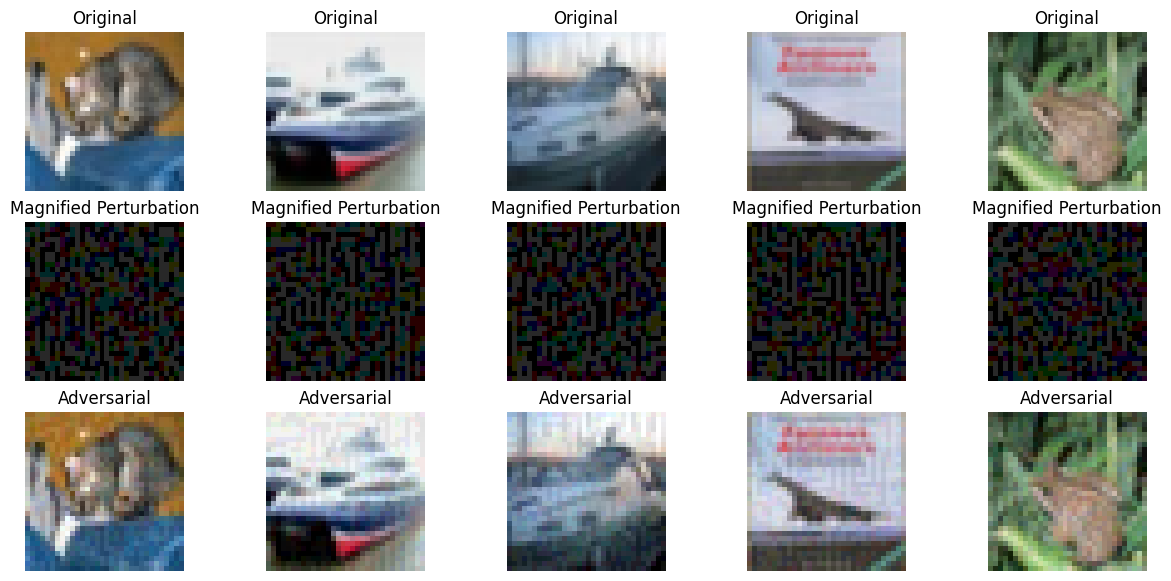

In [ ]:
import matplotlib.pyplot as plt
# Now show the 5 original test images mentioned in the previous cell
# And the FGSM perturbation added to each image (with epsilon = 8/255)
# Then the adversarial example created on the same 5 test images using the mentioned FGSM perturbation
#############################
# Your code goes here
fig = plt.figure(figsize=(15, 7))
for i in range(5):
  sub = fig.add_subplot(3, 5, i+1)
  sub.set_title('Original')
  sub.axis('off')
  plt.imshow(torch.tensor(originals[i]).permute(1,2,0))

  sub = fig.add_subplot(3, 5, i+6)
  sub.set_title('Magnified Perturbation')
  sub.axis('off')
  plt.imshow(torch.tensor(perturbations[i]*5).permute(1,2,0))

  sub = fig.add_subplot(3, 5, i+11)
  sub.set_title('Adversarial')
  sub.axis('off')
  plt.imshow(torch.tensor(adversarials[i]).permute(1,2,0))
#############################

# [11] **Adversarial Training**

In [ ]:
# Now train a ResNet model with FGSM adversarial examples crafted on CIFAR10 trainset
# Then report the clean accuracy of this adversarially trained network on the clean CIFAR10 testset
# Also report the adversarial accuracy of this adversarially trained network against FGSM with epsilon = 8/255 on the CIFAR10 testset
# Try using a scheduler for the learning rate (if needed)
#############################
# Your code goes here

model_adv = ResNet18()
model_adv = model_adv.to(device)
model_adv.train()

epochs = 100
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_adv.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epsilon = 8/255

for epoch in range(epochs):  

    print("epoch " + str(epoch))
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        images, labels = data[0].to(device), data[1].to(device)
        images.requires_grad = True
        model_adv.zero_grad()
        outs = model_adv(images)
        loss = F.nll_loss(outs, labels)
        loss.backward()
        images_grad = images.grad.data
        sign_gradient = images_grad.sign()
        perturbations = epsilon * sign_gradient
        perturbed_images = images + perturbations
        perturbed_images = torch.clamp(perturbed_images, 0, 1)

        model_adv.zero_grad()
        outputs = model_adv(perturbed_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1:    # print every 2000 mini-batches #1999
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.8f}')
            running_loss = 0.0

    scheduler.step()
    

print('Finished Training')
#############################

epoch 0
[1,     2] loss: 6.47364497
epoch 1
[2,     2] loss: 3.93870258
epoch 2
[3,     2] loss: 3.51958060
epoch 3
[4,     2] loss: 3.33482301
epoch 4
[5,     2] loss: 3.25017726
epoch 5
[6,     2] loss: 3.06210637
epoch 6
[7,     2] loss: 2.92744923
epoch 7
[8,     2] loss: 2.51232326
epoch 8
[9,     2] loss: 2.10689437
epoch 9
[10,     2] loss: 2.26749074
epoch 10
[11,     2] loss: 1.86843634
epoch 11
[12,     2] loss: 1.71688169
epoch 12
[13,     2] loss: 1.29381388
epoch 13
[14,     2] loss: 1.12642264
epoch 14
[15,     2] loss: 0.90994355
epoch 15
[16,     2] loss: 0.77768424
epoch 16
[17,     2] loss: 0.57446980
epoch 17
[18,     2] loss: 0.44634944
epoch 18
[19,     2] loss: 0.32111594
epoch 19
[20,     2] loss: 0.18668624
epoch 20
[21,     2] loss: 0.13219501
epoch 21
[22,     2] loss: 0.11762229
epoch 22
[23,     2] loss: 0.06010689
epoch 23
[24,     2] loss: 0.10859151
epoch 24
[25,     2] loss: 0.04983833
epoch 25
[26,     2] loss: 0.05956908
epoch 26
[27,     2] loss: 0.03

In [ ]:
model_adv.eval()
model_name = "resnet18_cifar10_model_adv"
CIFAR10_model_adv_PATH = "/content/drive/MyDrive/" + model_name
torch.save(model_adv.state_dict(), CIFAR10_model_adv_PATH)

In [5]:
model_name = "resnet18_cifar10_model_adv"
CIFAR10_model_adv_PATH = "/content/drive/MyDrive/" + model_name
model_adv = ResNet18()
state_dict = torch.load(CIFAR10_model_adv_PATH)
model_adv.load_state_dict(state_dict)
model_adv = model_adv.to(device)

In [ ]:
model_adv.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_adv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Adversarialy trained ResNet18 model on the 10000 clean test images: {100 * correct / total} %')

#############################
model_adv.eval()
correct = 0
total = 0

with torch.no_grad():
    for adversarial, truth in zip(adversarials, truths) :
        adversarial = torch.tensor(adversarial).to(device)
        outputs = model_adv(adversarial.unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == truth).sum().item()

print(f'Accuracy of Adversarialy trained ResNet18 model on the adversarial test images: {100 * correct / total} %')

Accuracy of Adversarialy trained ResNet18 model on the 10000 clean test images: 74.11 %
Accuracy of Adversarialy trained ResNet18 model on the adversarial test images: 77.60141093474427 %


# **Implementing PGD**

# [12] Projected Gradient Descent
You must complete the required sections with proper code for PGD attack

In [6]:
class LinfPGDAttack(object):

    def __init__(self, model, epsilon = 8/255, k = 2, alpha = 2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha
        self.originals = []
        self.perturbations = []
        self.adversarials = []
        self.truths = []
        self.adversarials_predicted = []
        self.falseImage = []
        self.falseImageTrueLabel = []

    def __call__(self, image, label):
      image = image.to(device)
      label = label.to(device)

      true_image = image.clone()    
      image.requires_grad = True
      out = self.model(image)
      _, pred = torch.max(out.data, 1)
      if pred.item() == label.item():

          perturbed_image = image.clone()

          # Now use the input information of the class to implement a k step PGD attack
          # of size alpha while always staying within epsilon distance from the initial point
          # Use cross entropy loss
          #############################
          # Your code goes here
          perturbed_image = image + torch.FloatTensor(np.random.uniform(-self.epsilon, self.epsilon, image.shape)).to(device)
          perturbed_image = torch.clamp(perturbed_image, 0, 1)
          for i in range(self.steps):
            perturbed_image = Variable(perturbed_image)
            perturbed_image.requires_grad = True
            out = self.model(perturbed_image)
            loss = F.cross_entropy(out, label)
            self.model.zero_grad()
            loss.backward()
            delta = perturbed_image.grad.sign() * self.alpha
            perturbed_image = perturbed_image + delta
            perturbed_image = torch.clamp(perturbed_image, image - self.epsilon, image + self.epsilon)
            perturbed_image = torch.clamp(perturbed_image, 0, 1)
          ############################# 

          out2 = self.model(perturbed_image)
          _, pred2 = torch.max(out2.data, 1)
          self.originals.append(true_image.squeeze().detach().cpu().numpy())
          self.perturbations.append(delta.squeeze().detach().cpu().numpy())
          self.adversarials.append(perturbed_image.squeeze().detach().cpu().numpy())
          self.truths.append(label.item())
          self.adversarials_predicted.append(pred2.item())
      else:
          self.falseImage.append(true_image.squeeze().detach().cpu().numpy())
          self.falseImageTrueLabel.append(label.item())

      return self.originals, self.perturbations, self.adversarials, self.truths, self.adversarials_predicted, self.falseImage, self.falseImageTrueLabel

# [13] Evaluating PGD Accuracy of Adversarially Trained Model and Standard Trained Model

In [ ]:
# Now launch the attack with the proper inputs for the whole CIFAR10 testset (with epsilon = 8/255)
# on the adversarially trained model and the standard trained model with 2 different step settings: k = 2 and k = 4
# Then print the PGD Accuracy for the images crafted with these 2 settings on the defended model and the standard model

# By PGD Accuracy we mean check if the adversarially trained model could still understand the true label that must be predicted
# Or will the model still get fooled by the PGD attack again after the FGSM adversarial training?
#############################
# Your code goes here
############################# k=2, standard model #############################
pgd_attack = LinfPGDAttack(model)

correct = 0
total = 0

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device) 
    for image, label in zip(images, labels):
      _, _, _, truths, adversarials_pred, _, _ = pgd_attack(image.unsqueeze(0), label.unsqueeze(0))

for i in range(len(adversarials_pred)):
  total += 1
  if adversarials_pred[i] == truths[i]:
    correct += 1

accuracy = 100 * correct / total
print('Accuracy of the standard model on the pgd adversarial test images with epsilon = {} and k = {} is {:.2f}%'.format(epsilon, 2, accuracy))

############################# k=4, standard model #############################
pgd_attack = LinfPGDAttack(model, k=4)

correct = 0
total = 0

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device) 
    for image, label in zip(images, labels):
      _, _, _, truths, adversarials_pred, _, _ = pgd_attack(image.unsqueeze(0), label.unsqueeze(0))

for i in range(len(adversarials_pred)):
  total += 1
  if adversarials_pred[i] == truths[i]:
    correct += 1

accuracy = 100 * correct / total
print('Accuracy of the standard model on the pgd adversarial test images with epsilon = {} and k = {} is {:.2f}%'.format(epsilon, 4, accuracy))

##################### k=2, adversarialy trained model ########################
pgd_attack_adv = LinfPGDAttack(model_adv)

correct_adv = 0
total_adv = 0

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device) 
    for image, label in zip(images, labels):
      _, _, _, truths, adversarials_pred, _, _ = pgd_attack_adv(image.unsqueeze(0), label.unsqueeze(0))

for i in range(len(adversarials_pred)):
  total_adv += 1
  if adversarials_pred[i] == truths[i]:
    correct_adv += 1

accuracy = 100 * correct_adv / total_adv
print('Accuracy of the adversarialy trained model on the pgd adversarial test images with epsilon = {} and k = {} is {:.2f}%'.format(epsilon, 2, accuracy))

##################### k=4, adversarialy trained model ########################
pgd_attack_adv = LinfPGDAttack(model_adv, k=4)

correct_adv = 0
total_adv = 0

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device) 
    for image, label in zip(images, labels):
      _, _, _, truths, adversarials_pred, _, _ = pgd_attack_adv(image.unsqueeze(0), label.unsqueeze(0))

for i in range(len(adversarials_pred)):
  total_adv += 1
  if adversarials_pred[i] == truths[i]:
    correct_adv += 1

accuracy = 100 * correct_adv / total_adv
print('Accuracy of the adversarialy trained model on the pgd adversarial test images with epsilon = {} and k = {} is {:.2f}%'.format(epsilon, 4, accuracy))
############################# 

Accuracy of the standard model on the pgd adversarial test images with epsilon = 0.03137254901960784 and k = 2 is 0.54%
Accuracy of the standard model on the pgd adversarial test images with epsilon = 0.03137254901960784 and k = 4 is 0.00%
Accuracy of the adversarialy trained model on the pgd adversarial test images with epsilon = 0.03137254901960784 and k = 2 is 87.27%
Accuracy of the adversarialy trained model on the pgd adversarial test images with epsilon = 0.03137254901960784 and k = 4 is 64.05%


# [14] Plotting

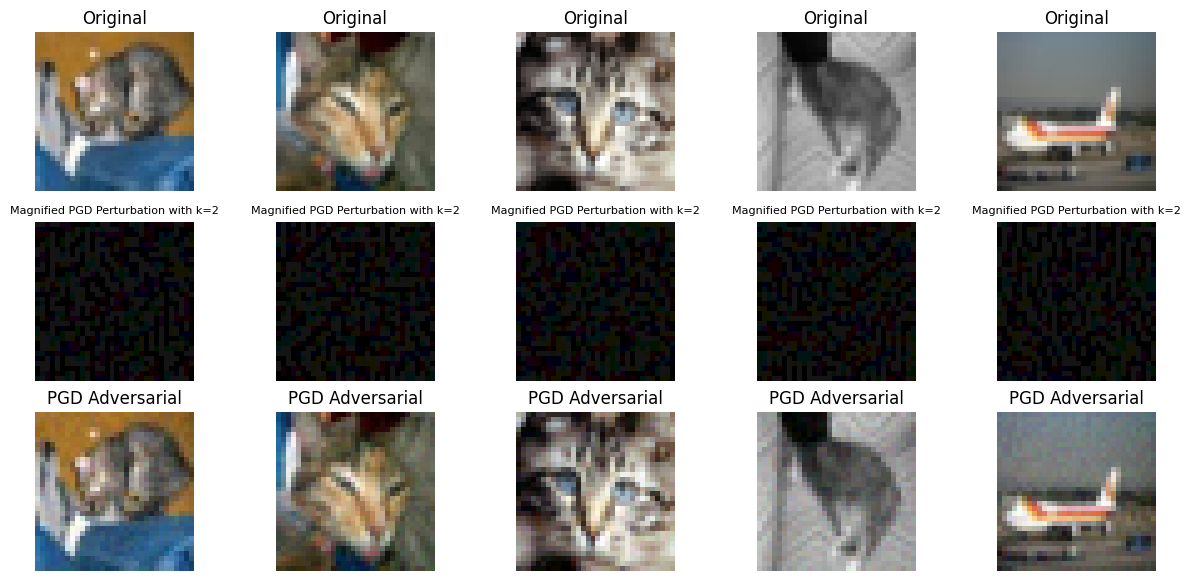

In [ ]:
import matplotlib.pyplot as plt
# Now show 5 original test images from the CIFAR10 testset 
# And the PGD perturbation added to each image (with epsilon = 8/255)
# Then the adversarial example created on the same 5 test images using the mentioned PGD perturbation
#############################
# Your code goes here
pgd_attack = LinfPGDAttack(model)
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device) 
    for image, label in zip(images, labels):
      originals, perturbations, adversarials, _, _, _, _ = pgd_attack(image.unsqueeze(0), label.unsqueeze(0))
      if len(originals) >= 5:
        break
      break


fig = plt.figure(figsize=(15, 7))
for i in range(5):
  sub = fig.add_subplot(3, 5, i+1)
  sub.set_title('Original')
  sub.axis('off')
  plt.imshow(torch.tensor(originals[i]).permute(1,2,0))

  sub = fig.add_subplot(3, 5, i+6)
  sub.set_title('Magnified PGD Perturbation with k=2', fontsize=8)
  sub.axis('off')
  plt.imshow(torch.tensor(perturbations[i]*10).permute(1,2,0))

  sub = fig.add_subplot(3, 5, i+11)
  sub.set_title('PGD Adversarial')
  sub.axis('off')
  plt.imshow(torch.tensor(adversarials[i]).permute(1,2,0))
#############################

# [15] Noisy Input Accuracy

In [ ]:
# Add Gaussian noise with mean of 0 and variance of 6/255 to the CIFAR10 testset
# Evaluate the accuracy of these noisy images on the standard trained model and the adversarially trained model
# What do you conclude from the results of applying noisy inputs and adversarial example inputs to both of the models?
#############################
# Your code goes here
noise_std = torch.sqrt(torch.tensor(6/255))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * noise_std)

])

model.eval()
correct = 0
total = 0
to_pil = transforms.ToPILImage()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        images_transformed = []
        for image in images:
          images_transformed.append(torch.tensor(transform(to_pil(image))))
        outputs = model(torch.stack(images_transformed).to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Standard ResNet18 model on the 10000 test images with 0 mean and 6/255 variance gaussian noise: {100 * correct / total} %')


#############################
model_adv.eval()
correct = 0
total = 0
to_pil = transforms.ToPILImage()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        images_transformed = []
        for image in images:
          images_transformed.append(torch.tensor(transform(to_pil(image))))
        outputs = model_adv(torch.stack(images_transformed).to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Adversarialy trained ResNet18 model on the 10000 test images with 0 mean and 6/255 variance gaussian noise: {100 * correct / total} %')
#############################

<ipython-input-9-6dd6d196acdb>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_transformed.append(torch.tensor(transform(to_pil(image))))


Accuracy of Standard ResNet18 model on the 10000 test images with 0 mean and 6/255 variance gaussian noise: 31.3 %


<ipython-input-9-6dd6d196acdb>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_transformed.append(torch.tensor(transform(to_pil(image))))


Accuracy of Adversarialy trained ResNet18 model on the 10000 test images with 0 mean and 6/255 variance gaussian noise: 62.92 %


# [16] Logit VS Epsilon Test

In [27]:
# Pick the first image x from the CIFAR10 testset
# Make sure the prediction for this image is done correctly by the standard trained model
# Compute the gradient of the model's loss with respect to the image x
# Now for the epsilon values between -0.5 and 0.5 with step size of 0.01 (101 different values),
# Compute x + \epsilon.sign(\nabla_x J(W, x, y))
# Get the logit value for these 101 different images (by logit we mean the softmax input)
# Then plot the logit value vs the epsilon value diagram
# Now choose a random direction instead of \nabla_x J(W, x, y), from the Uniform basis between -1 and 1 for each dimension
# Plot the logit value vs the epsilon value diagram with respect to the new direction
# What is your conclusion based on the results achieved from the two digrams?
#############################
# Your code goes here
for images, labels in testloader:
  for image, label in zip(images, labels):
    image, label = image.to(device), label.to(device)
    image.requires_grad = True
    model.zero_grad()
    outs = model(image.unsqueeze(0))
    _, pred = torch.max(outs, 1)
    if pred.item() == label.item():
      loss = F.nll_loss(outs, label.unsqueeze(0))
      loss.backward()
      image_grad = image.grad.data
      sign_gradient = image_grad.sign()
      random_direction = (torch.rand_like(image)-0.5)*2
      sign_random_direction = random_direction.sign()
      epsilons = np.linspace(-0.5, 0.5, 100).tolist()
      logits_preturbed = []
      logits_rand = []
      for epsilon in epsilons:
        perturbation = epsilon * sign_gradient
        perturbed_image = image + perturbation
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        logits_preturbed.append(model(perturbed_image.unsqueeze(0).to(device)).detach().cpu().numpy().reshape(-1))

        random_perturbation = epsilon * sign_random_direction
        random_perturbed_image = image + random_perturbation
        random_perturbed_image = torch.clamp(random_perturbed_image, 0, 1)
        logits_rand.append(model(random_perturbed_image.unsqueeze(0).to(device)).detach().cpu().numpy().reshape(-1))
      break
  break
#############################

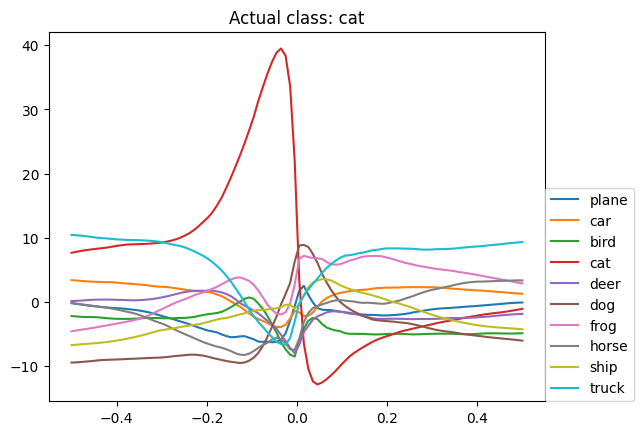

In [28]:
for i in range(10):
  plt.plot(epsilons, [l[i] for l in logits_preturbed], label=classes[i])
plt.title(f'Actual class: {classes[label]}')
plt.legend(loc=(1,0))
plt.show()

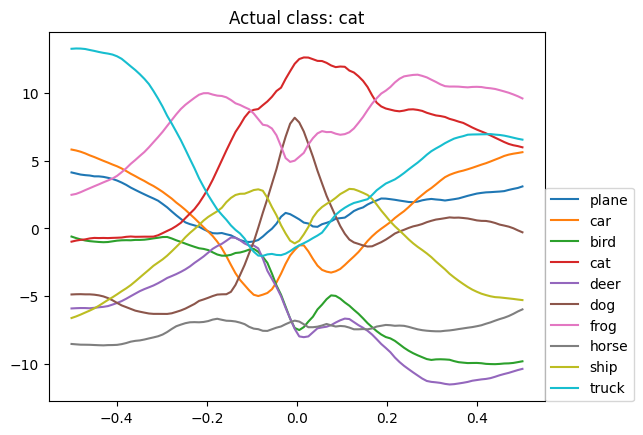

In [29]:
for i in range(10):
  plt.plot(epsilons, [l[i] for l in logits_rand], label=classes[i])
plt.title(f'Actual class: {classes[label]}')
plt.legend(loc=(1,0))
plt.show()